# Goal
So the excellent [original kernel](https://www.kaggle.com/ahassaine/pure-image-processing-lb-0-274) put together by [Ali](https://www.kaggle.com/ahassaine) gets 0.274 "without even using the training data" which is a great result, but what if we use the training data.  
## Overview
The idea is to take the parameters found in the original kernel and try to improve them using the IOU score as the ground criteria.
1. Get a cross-validation setup working that gives us a similar value to the 0.274
1. Rewrite the threshold and label methods to take all of their parameters
1. Use scipy.optimize (probably sk-optimize would be better, but we'll keep it simple here) to improve the values
1. Predict and submit

In [468]:
from os.path import join
import cv2
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from glob import glob
import os
from skimage.io import imread
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(color_codes=True)
%matplotlib inline
from skimage.color import rgb2grey, rgb2hsv
from skimage import img_as_float, img_as_ubyte

from sklearn.model_selection import train_test_split
from skimage.morphology import label
from skimage import img_as_float, exposure

from scipy.optimize import minimize
from tqdm import tqdm

import utils
from utils import iou_metric, diagnose_errors, add_contour, show_img

dsb_data_dir = os.path.join('..', '..', 'input')
stage_label = 'stage1'

In [4]:
all_images = glob(os.path.join(dsb_data_dir, 'stage1_*', '*', '*', '*'))
img_df = pd.DataFrame({'path': all_images})
img_id = lambda in_path: in_path.split('/')[-3]
img_type = lambda in_path: in_path.split('/')[-2]
img_group = lambda in_path: in_path.split('/')[-4].split('_')[1]
img_stage = lambda in_path: in_path.split('/')[-4].split('_')[0]
img_df['ImageId'] = img_df['path'].map(img_id)
img_df['ImageType'] = img_df['path'].map(img_type)
img_df['TrainingSplit'] = img_df['path'].map(img_group)
img_df['Stage'] = img_df['path'].map(img_stage)
img_df.sample(2)
img_df.describe()

,path,ImageId,ImageType,TrainingSplit,Stage
count,30196,30196,30196,30196,30196
unique,30196,735,2,2,1
top,../../input/stage1_train/04acab7636c4cf61d288a...,a102535b0e88374bea4a1cfd9ee7cb3822ff54f4ab2a98...,masks,train,stage1
freq,1,376,29461,30131,30196


# Process and Import Training Data
Here we load in the training data images and labels. We load the label images into a single index colored integer image.

In [5]:
train_df = img_df.query('TrainingSplit=="train"')
train_rows = []
group_cols = ['Stage', 'ImageId']
for n_group, n_rows in train_df.groupby(group_cols):
    c_row = {col_name: col_value for col_name, col_value in zip(group_cols, n_group)}
    c_row['masks'] = n_rows.query('ImageType == "masks"')['path'].values.tolist()
    c_row['images'] = n_rows.query('ImageType == "images"')['path'].values.tolist()
    train_rows += [c_row]


In [469]:
train_img_df = pd.DataFrame(train_rows)    
IMG_CHANNELS = 3
def read_and_stack(in_img_list):
    return np.sum(np.stack([i*(imread(c_img)>0) for i, c_img in enumerate(in_img_list, 1)], 0), 0)

def read_hist_bw(in_img_list):
    return rgb2hsv(cv2.imread(in_img_list[0]))[:,:,1]
    #return cv2.imread(in_img_list[0])[:,:,1]

In [470]:
%%time
train_img_df['images'] = train_img_df['images'].map(read_hist_bw)
train_img_df['masks'] = train_img_df['masks'].map(read_and_stack).map(lambda x: x.astype(int))
train_img_df.sample(1)

CPU times: user 2min 9s, sys: 57.8 s, total: 3min 7s
Wall time: 3min 11s


float64


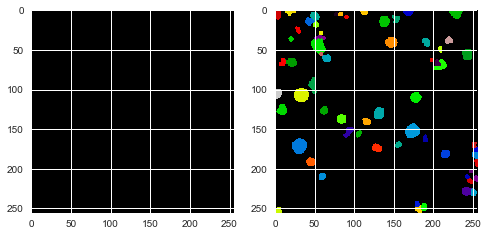

In [471]:
for _, c_row in train_img_df.sample(1).iterrows():
    fig, (ax1, ax2) = plt.subplots(1,2, figsize = (8, 4))
    ax1.imshow(c_row['images'], cmap = 'bone')
    ax2.imshow(c_row['masks'], cmap = 'nipy_spectral')
    print img.dtype

In [472]:
train_split_df, valid_split_df = train_test_split(train_img_df, 
                                                  test_size = 0.2, 
                                                  random_state = 2018,
                                                  # ensures both splits have the different sized images
                                                  stratify = train_img_df['images'].map(lambda x: '{}'.format(np.shape))
                                                 )
print('train', train_split_df.shape, 'valid', valid_split_df.shape)


('train', (536, 4), 'valid', (134, 4))


# Wrap Everything Up
We have a single function to evaluate the IOU of a model on a dataset

In [9]:
def calculate_iou(in_df, thresh_func):
    pred_masks = in_df['images'].map(thresh_func).values
    gt_masks = in_df['masks'].values
    all_ious = [iou_metric(cur_gt, cur_pred, print_table=False) for cur_gt, cur_pred in 
            zip(gt_masks, pred_masks)]
    return np.mean(all_ious)

# Define a Parametric Model
Here we take the basic Gabor pipeline and allow the important parameters to be adjusted so they can consequently be optimized

In [475]:
def parametric_pipeline(img_green,
                invert_thresh_pd = 10,
                circle_size = 7,
                min_distance=7
                ):
    circle_size = np.clip(int(circle_size), 1, 30)
    
    #green channel happends to produce slightly better results
    #than the grayscale image and other channels
    #morphological opening (size tuned on training data)
    circle7=cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(circle_size, circle_size))
    img_open=cv2.morphologyEx(img_green, cv2.MORPH_OPEN, circle7)
    # isodata thresholding is comparable to otsu ...
    #Otsu thresholding
    #try:
    #    th = skimage.filters.threshold_local(img_open)
    #    img_th=cv2.threshold(img_open,th,255,cv2.THRESH_BINARY)[1]
    #except:
    img_grey = img_as_ubyte(img_open)
    img_th=cv2.threshold(img_grey,0,255,cv2.THRESH_OTSU)[1]
    #Invert the image in case the objects of interest are in the dark side
    if(np.sum(img_th==255)>((invert_thresh_pd/10.0)*np.sum(img_th==0))):
        img_th=cv2.bitwise_not(img_th)
    #second morphological opening (on binary image this time)
    bin_open=cv2.morphologyEx(img_th, cv2.MORPH_OPEN, circle7)
    
    #ll = bin_open
    # watershed segmentation
    #img_dist = ndimage.distance_transform_edt(ll)
    #local_maxi = peak_local_max(img_dist,labels=ll,
    #                        min_distance=min_distance,
    #                            footprint=np.ones((20,20)),
    #                         indices=False)
    #markers = ndi.label(local_maxi)[0]
    
    #cc = watershed(-img_dist, markers, mask=ll,compactness=0)
    #connected components
    cc=cv2.connectedComponents(bin_open)[1]
    #cc=segment_on_dt(bin_open,20)
    return cc

img_th=skimage.filters.threshold_minimum(img_open)

#img_th, img_otsu=cv2.threshold(img_open,0,255,cv2.THRESH_OTSU)
#img_th,img_otsu=cv2.threshold(img_open,250,255,cv2.THRESH_BINARY)
print img_th
img_otsu = img_open > img_th

def parametric_pipeline_orig(img_green,
                invert_thresh_pd = 10,
                circle_size = 7,
                ):
    circle_size = np.clip(int(circle_size), 1, 30)
    
    #green channel happends to produce slightly better results
    #than the grayscale image and other channels
    #morphological opening (size tuned on training data)
    circle7=cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(circle_size, circle_size))
    img_open=cv2.morphologyEx(img_green, cv2.MORPH_OPEN, circle7)
    #Otsu thresholding
    img_th=cv2.threshold(img_open,0,255,cv2.THRESH_OTSU)[1]
    #Invert the image in case the objects of interest are in the dark side
    if(np.sum(img_th==255)>((invert_thresh_pd/10.0)*np.sum(img_th==0))):
        img_th=cv2.bitwise_not(img_th)
    #second morphological opening (on binary image this time)
    bin_open=cv2.morphologyEx(img_th, cv2.MORPH_OPEN, circle7) 
    #connected components
    cc=cv2.connectedComponents(bin_open)[1]
    #cc=segment_on_dt(bin_open,20)
    return cc

208


# Single Evaluation

In [476]:
print calculate_iou(train_split_df, lambda x: parametric_pipeline(x,10,7,7))

0.0302852620823


# Diagnosis

2dd3356f2dcf470aec4003800744dfec6490e75d88011e1d835f4f3d60f88e7a


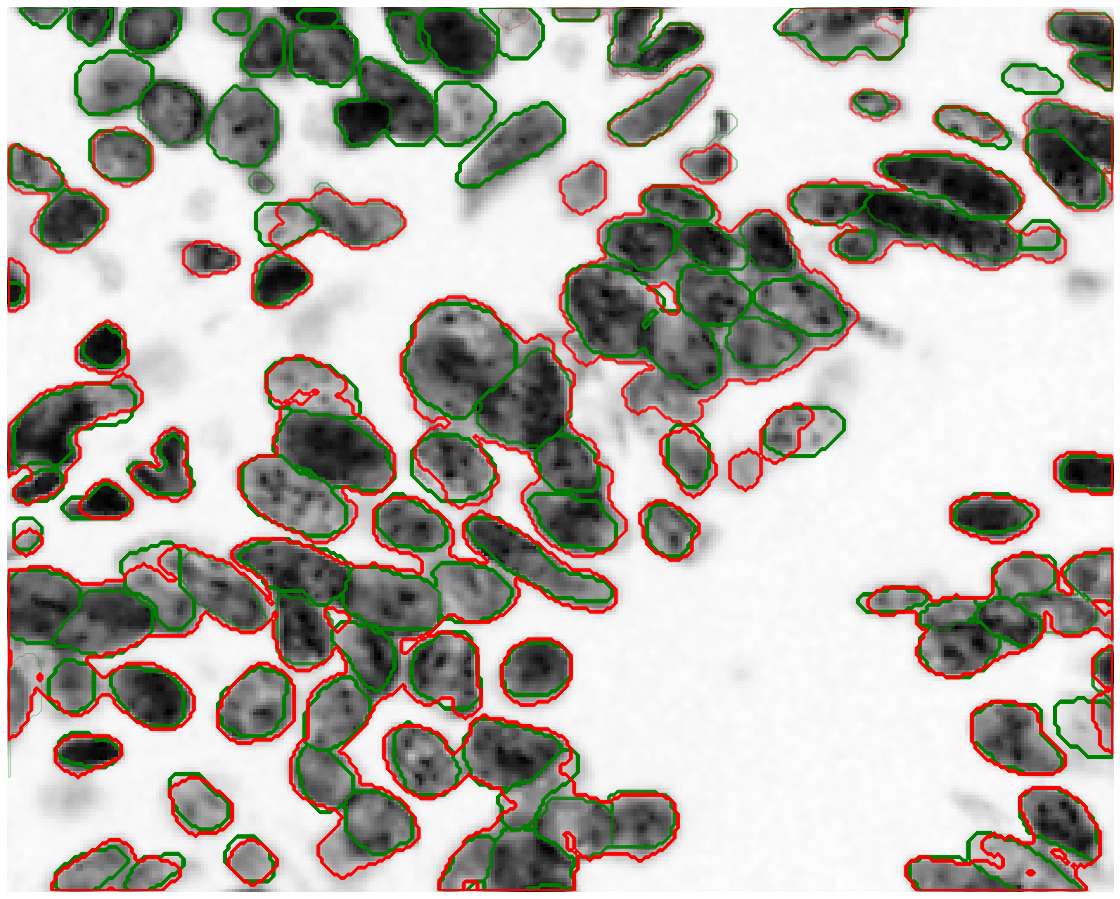

average precision: 9.6 %; max score improvment without mislocations: 23.7 %; missed 34.9 % of positives; predicted 2.1 % false positives;  10.3 % of predictions covering multiple objects; segments tend to be too large: pixel precision: 82.1 %, pixel recall: 93.0 %


(0.095890410958904104,
 0.23744292237442921,
 0.82107097326247036,
 0.92958969713819906,
 0.34931506849315069,
 0.020547945205479451,
 0.0,
 0.10273972602739725)

In [479]:
def diag_fun(row):
     pred_masks = parametric_pipeline(row['images'], 10, 7)
     return diagnose_errors(row['masks'], pred_masks, threshold=0.7, print_message=False)

diags = [diag_fun(row) for _,row in train_img_df.iterrows()]
for i, k in enumerate(['p', 'p_loc', 'mean_prec', 'mean_rec', 'missed_rate', 'extra_rate', 'oseg', 'useg']):
    train_img_df[k] = [x[i] for x in diags]

train_img_df.describe()

thresh = 0.7
sel = 0.0
sel_var = 'p'
ex = train_img_df[(train_img_df[sel_var]>sel) & (train_img_df[sel_var] <= sel+0.1)].iloc[2]

def show_compare_gt(row, thresh):
    pred_masks = parametric_pipeline(row['images'], 10, 7, 20)
    fig, ax = plt.subplots(1, 1, figsize=(16, 16))
    ax.grid(None)
    ax.imshow(row['images'])
    add_contour(row['masks'], ax, 'green')
    add_contour(pred_masks, ax, 'red')
    plt.tight_layout()
    plt.xticks([])
    plt.yticks([])
    plt.show()
    return diagnose_errors(ex['masks'], pred_masks, thresh, print_message=True)

print ex['ImageId']

show_compare_gt(ex, thresh)

    
#show_img(ex['images'])


In [267]:
train_img_df.describe()

,p,p_loc,mean_prec,mean_rec,missed_rate,extra_rate,oseg,useg
count,670.000000,670.000000,650.000000,650.000000,670.000000,670.000000,670.000000,670.000000
mean,0.496140,0.227288,0.946991,0.925916,0.112205,0.020296,0.003790,0.071549
std,0.302874,0.176035,0.043857,0.049160,0.157946,0.072057,0.015228,0.056790
min,0.000000,0.000000,0.733068,0.703252,0.000000,0.000000,0.000000,0.000000
25%,0.232287,0.106629,0.924197,0.906292,0.007897,0.000000,0.000000,0.019231
50%,0.514333,0.215348,0.958269,0.936814,0.060606,0.000000,0.000000,0.071429
75%,0.735965,0.308817,0.980411,0.959755,0.142857,0.000000,0.000000,0.111111
max,1.000000,0.958333,1.000000,1.000000,0.994924,0.986111,0.200000,0.333333


In [284]:
utils = reload(utils)
#import sys
#modulenames = set(sys.modules)&set(globals())
#allmodules = [sys.modules[name] for name in modulenames]
#print allmodules

188.0
invert


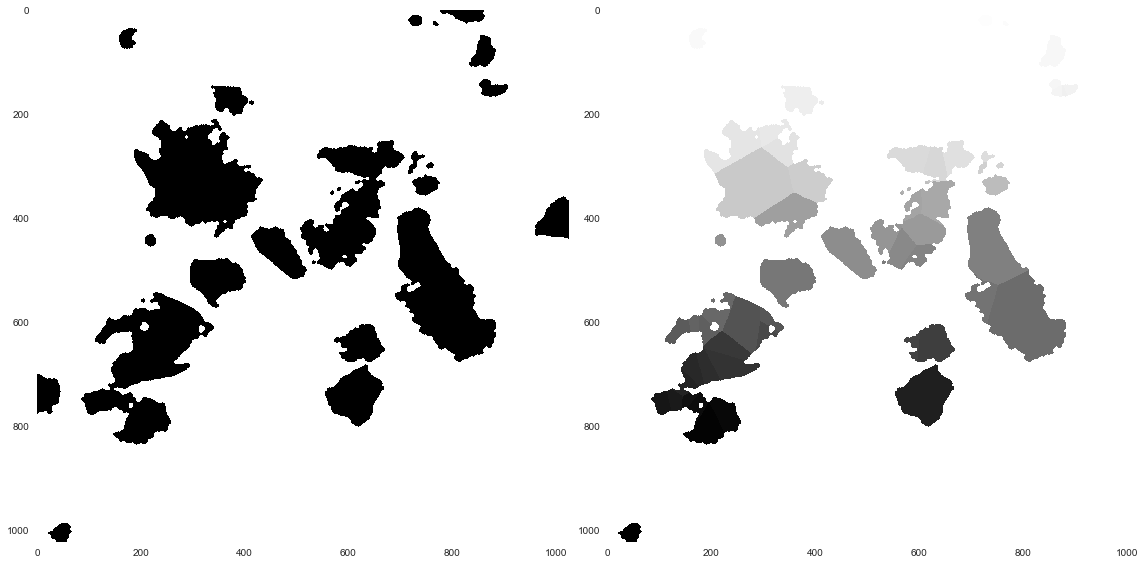

70.8307842679 0.0
66 0


In [478]:
#import skimage
#from scipy import ndimage
#from skimage.feature import peak_local_max
from scipy import ndimage as ndi
from skimage.morphology import watershed
from skimage.segmentation import random_walker, felzenszwalb


img = ex['images']
#fig, ax = plt.subplots(1, 1, figsize=(16, 16))
#ax.grid(None)
#ax.imshow(img)
#plt.show()

circle_size = 7
invert_thresh_pd = 10
circle7=cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(circle_size, circle_size))
img_open=cv2.morphologyEx(img, cv2.MORPH_OPEN, circle7)
#img_th=skimage.filters.threshold_isodata(img_open)

img_th, img_otsu=cv2.threshold(img_open,0,255,cv2.THRESH_OTSU)
#img_th,img_otsu=cv2.threshold(img_open,img_th,255,cv2.THRESH_BINARY)
print img_th
#img_otsu = (img_open > img_th).astype(int)
#print 'max', img_otsu.max(), img_otsu.min()
#print img_otsu.shape
#print img_open.shape
#fig,ax = plt.subplots(1,2,figsize=(16, 16))
#plot_img_and_hist(img_open,ax)
#show_img([img_open,img_otsu])

#from skimage.filters import try_all_threshold
#fig, ax = try_all_threshold(img_open, figsize=(10, 8), verbose=False)
#plt.show()


#Invert the image in case the objects of interest are in the dark side
if(np.sum(img_otsu==255)>((invert_thresh_pd/10.0)*np.sum(img_otsu==0))):
    print 'invert'
    img_otsu=cv2.bitwise_not(img_otsu)
#second morphological opening (on binary image this time)
bin_open=cv2.morphologyEx(img_otsu, cv2.MORPH_OPEN, circle7)
ll = bin_open # cv2.bitwise_not(bin_open)
img_dist = ndimage.distance_transform_edt(ll)
 

#ll = bin_open
local_maxi = peak_local_max(img_dist,labels=ll,
                            min_distance=7,
                             indices=False)
markers = ndi.label(local_maxi)[0]


labels = watershed(-img_dist, markers, mask=ll,compactness=1)
#labels = random_walker(-img_dist, markers, beta=500)
#abels = felzenszwalb(-img_dist)
#labels = morphological_chan_vese(img_dist)
show_img([bin_open,labels])
print img_dist.max(), img_dist.min()
print markers.max(), markers.min()

#
#connected components
#cc=cv2.connectedComponents(bin_open)[1]
#cc=segment_on_dt(bin_open,20)
#return cc




# Optimization
A very simple optimization routine with no knowledge about morphology, integer steps, iterations or anything else. It just serves as an example of how such a pipeline can be optimized. The random search is also very primitive, a better package would improve this massively.

In [204]:

base_x0_min = [10, 1]
base_x0_max = [10, 20]

def random_search_fmin(random_restart = 5, search_steps = 5, base_x0=(10,7)):
    results = []
    for it in tqdm(range(random_restart)):
        def inv_iou_func(x0):
            try:
                score = calculate_iou(train_split_df, 
                                      lambda x: parametric_pipeline(x, *x0))
            except Exception as e:
                print('Arguments:', ' '.join(['%1.1f' % xi for xi in x0]))
                raise ValueError(e)
            print('Arguments:', ' '.join(['%1.1f' % xi for xi in x0]), 
                  'IOU: %2.3f' % score)
            return 1-score # since we are minimizing the result

        opt_params = minimize(inv_iou_func,
                              base_x0,
                              method='powell',
                              #bounds=zip(base_x0_min, base_x0_max),
                              options={'xtol':0.5,
                                       'ftol':0.05,
                              'maxiter':search_steps}
                              )
        
        results.append(opt_params)
        # pick a new random spot to iterate from
        base_x0 = [np.random.choice(np.linspace(x_start, x_end, x_end - x_start + 1))
                   for x_start, x_end in zip(base_x0_min, base_x0_max)]
    n_out = sorted(results, key = lambda o: 1.0-float(o.fun))
    return float(n_out[0].fun), n_out


In [207]:
%%time
best, results = random_search_fmin(2, 2, (10,3))
print best, results



  0%|          | 0/2 [00:00<?, ?it/s]
Exception in thread Thread-36:
Traceback (most recent call last):
  File "/Users/stefan/anaconda2/lib/python2.7/threading.py", line 801, in __bootstrap_inner
    self.run()
  File "/Users/stefan/anaconda2/lib/python2.7/site-packages/tqdm/_tqdm.py", line 144, in run
    for instance in self.tqdm_cls._instances:
  File "/Users/stefan/anaconda2/lib/python2.7/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration



('Arguments:', '10.0 3.0', 'IOU: 0.424')
('Arguments:', '10.0 3.0', 'IOU: 0.424')
('Arguments:', '11.0 3.0', 'IOU: 0.424')
('Arguments:', '12.6 3.0', 'IOU: 0.424')
('Arguments:', '11.0 3.0', 'IOU: 0.424')
('Arguments:', '11.0 3.0', 'IOU: 0.424')
('Arguments:', '11.0 4.0', 'IOU: 0.240')
('Arguments:', '11.0 1.4', 'IOU: 0.400')
('Arguments:', '11.0 3.0', 'IOU: 0.424')
('Arguments:', '11.0 2.4', 'IOU: 0.236')


KeyboardInterrupt: 

[]

# Calculate the Score on Hold-Out (validation)
Here we calculate the score on the validation to see if we actually improved anything

In [ ]:
print('Opt Parameters', opt_params)
print('IOU', calculate_iou(valid_split_df, 
                           lambda x: parametric_pipeline(x, *opt_params)))

Now we load the test images and apply the algorithm to them

In [ ]:
%%time
test_df = img_df.query('TrainingSplit=="test"')
test_rows = []
group_cols = ['Stage', 'ImageId']
for n_group, n_rows in test_df.groupby(group_cols):
    c_row = {col_name: col_value for col_name, col_value in zip(group_cols, n_group)}
    c_row['images'] = n_rows.query('ImageType == "images"')['path'].values.tolist()
    test_rows += [c_row]
test_img_df = pd.DataFrame(test_rows)    

test_img_df['images'] = test_img_df['images'].map(read_hist_bw)
print(test_img_df.shape[0], 'images to process')
test_img_df.sample(1)

In [ ]:
%%time
test_img_df['masks'] = test_img_df['images'].map(lambda x: 
                                                 parametric_pipeline(x, *opt_params))

In [ ]:
n_img = 3
fig, m_axs = plt.subplots(2, n_img, figsize = (12, 6))
for (_, d_row), (c_im, c_lab) in zip(test_img_df.sample(n_img).iterrows(), 
                                     m_axs.T):
    c_im.imshow(d_row['images'])
    c_im.axis('off')
    c_im.set_title('Microscope')
    
    c_lab.imshow(d_row['masks'])
    c_lab.axis('off')
    c_lab.set_title('Predicted')

In [ ]:
def rle_encoding(x):
    '''
    x: numpy array of shape (height, width), 1 - mask, 0 - background
    Returns run length as list
    '''
    dots = np.where(x.T.flatten()==1)[0] # .T sets Fortran order down-then-right
    run_lengths = []
    prev = -2
    for b in dots:
        if (b>prev+1): run_lengths.extend((b+1, 0))
        run_lengths[-1] += 1
        prev = b
    return run_lengths

def prob_to_rles(x, cut_off = 0.5):
    lab_img = label(x>cut_off)
    if lab_img.max()<1:
        lab_img[0,0] = 1 # ensure at least one prediction per image
    for i in range(1, lab_img.max()+1):
        yield rle_encoding(lab_img==i)

In [ ]:
test_img_df['rles'] = test_img_df['masks'].map(lambda x: list(prob_to_rles(x)))

In [ ]:
out_pred_list = []
for _, c_row in test_img_df.iterrows():
    for c_rle in c_row['rles']:
        out_pred_list+=[dict(ImageId=c_row['ImageId'], 
                             EncodedPixels = ' '.join(np.array(c_rle).astype(str)))]
out_pred_df = pd.DataFrame(out_pred_list)
print(out_pred_df.shape[0], 'regions found for', test_img_df.shape[0], 'images')
out_pred_df.sample(3)

In [ ]:
out_pred_df[['ImageId', 'EncodedPixels']].to_csv('predictions.csv', index = False)